In [706]:
# Notebook to release Sentiment Analysis - prediction
# Iván Andrés Trujillo abella
# ivantrujillo1229@gmail.com

In [707]:
url = "https://raw.githubusercontent.com/it-ces/Datasets/refs/heads/main/tweets(ai-page).csv"

In [708]:
import emoji
import pandas as pd
import numpy as np

In [709]:
s = '😡'
code = 'U000{:X}'.format(ord(s))
print(code)

U0001F621


In [710]:
matches = ["U0001F621", "U0001F607"]
emojis = [emoji.replace('U', r"\U").encode().decode('unicode-escape') for emoji in matches]
print(emojis)

['😡', '😇']


In [711]:
print(emoji.is_emoji("\U0001F607"))
emoji.is_emoji("😡")

True


True

In [712]:
emoji.distinct_emoji_list("\U0001F607 hello world")

['😇']

In [713]:
df = pd.read_csv(url)

In [714]:
df

,tweet
0,miBanco D q se trata
1,¿Cómo proteger los negocios de la inflación? E...
2,miBanco 😁
3,miBanco En varias ocasiones informe que autori...
4,miBanco miBancoApp Ya está caído 😕
...,...
63704,"Oye @Davivienda, mi vale ¿qué? \n\n¿Se te pegó..."
63705,Siga creyendo que el boxer amarillo le va a qu...
63706,Cuanta miBanco porfa
63707,miBanco Me está pasando lo mismo con he abon...


In [715]:
df['emoticons']='None'
for index in df.index:
    if len(emoji.distinct_emoji_list(df.loc[index,'tweet']))>0:
        im = emoji.distinct_emoji_list(df.loc[index,'tweet'])
        df.loc[index, 'emoticons'] = im[0] # take the first emoticon
        
df  = df[df['emoticons']!='None'].reset_index(drop=True)       
        
def label_emoji(emojis):
    labels={'Angry':['🤬','😡', '😤','🤭'],
            'Smile':['😁','🤗', '😀'],
            'Nice':['😎','♥️','👍', '😍','👍🏾','😻','🙏🏽','🙌🏼',
                     '👏🏻','🦾', '🤘', '💪'],
            'No nice': ['🖕🏼','🤡','🤦','👎🏾','🥲' ,'😰'],
            'Sad':['😔', '😩','😢','😫', '😭' ]}
    class_name = 'Another'
    for emoticon in emojis:
        if emojis =='None':
            return 'None'
        for label in labels:
            if emoticon in labels[label]:
                class_name = label
    return class_name       

In [716]:
df['y'] = df['emoticons'].apply(lambda x: label_emoji(x))

In [717]:
## Using regular expressions to tackle
df['tweet'] = df['tweet'].apply(lambda x : emoji.replace_emoji(x, replace=''))
df['tweet'] = df['tweet'].apply(lambda x : x.lower())
df['tweet'] =df['tweet'].replace('mi[Bb]anco', "", regex=True)
regex_url = "https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
df['tweet'] = df['tweet'].replace(regex_url, "", regex=True)
df['tweet'] = df['tweet'].replace(r'\bhttps://t.co/[a-z0-9]*\b', "", regex=True)
df['tweet'] = df['tweet'].replace(r'[\d@#]', "", regex=True)

In [718]:
df

,tweet,emoticons,y
0,¿cómo proteger los negocios de la inflación? e...,👉,Another
1,,😁,Smile
2,app ya está caído,😕,Another
3,"av. regional a la altura de , movilidadmedell...",⚠️,Another
4,ingresa al sistema pagando con tus tarjetas dé...,✔️,Another
...,...,...,...
14286,app hoy estoy tratando de hacer una transferen...,💩,Another
14287,arreglen esa hijueputa aplicación incompetent...,💥,Another
14288,"hola, olvide la clave de .",👍,Nice
14289,comprar vivienda es una decisión definitiva pa...,👉,Another


In [719]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## To modeling
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from wordcloud import WordCloud


# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import re

# Random Forest
from sklearn.ensemble import RandomForestClassifier



In [720]:
df = df[df['y']!='Another']
df.reset_index(inplace=True, drop=True )

In [721]:
df['y'].value_counts()

y
Angry      1080
No nice     741
Sad         640
Nice        301
Smile        90
Name: count, dtype: int64

In [722]:
df['feeling'] = np.where((df['y']=='Smile') | (df['y']=='Nice'), 'Positive', 'Negative')

/var/folders/m6/dfg4_p055hl395w0zrtt6dcm0000gn/T/ipykernel_4342/3219961836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feeling'] = np.where((df['y']=='Smile') | (df['y']=='Nice'), 'Positive', 'Negative')


In [723]:
df['feeling'].value_counts()

feeling
Negative    2461
Positive     391
Name: count, dtype: int64

In [724]:
df

,tweet,emoticons,y,feeling
0,,😁,Smile,Positive
1,dejen de responder mierda que no funciona co...,😤,Angry,Negative
2,"hágale doc, ya le paso el de cuenta de",🤗,Smile,Positive
3,por primera vez leí eso del día a día de y de...,😔,Sad,Negative
4,"te odio, pero te necesito",😤,Angry,Negative
...,...,...,...,...
2847,me tiene la vida aburrida con su bloqueadera ...,😡,Angry,Negative
2848,si tienen la oportunidad de abrir cuenta en d...,🤬,Angry,Negative
2849,esto no es cierto! sigue caída,😡,Angry,Negative
2850,"hola, olvide la clave de .",👍,Nice,Positive


In [725]:
emojis = df['emoticons'].unique()
base_of_text={}
for emo in emojis:
    base_of_text[emo] = "".join(df[df['emoticons']==emo]['tweet'].values)

In [726]:
df['emoticons'].unique()

array(['😁', '😤', '🤗', '😔', '😡', '😭', '🤬', '🤡', '🤦🏾\u200d♂️', '😫', '👍',
       '😢', '🥲', '😩', '💪🏻', '🤦🏽\u200d♀️', '🤦🏽\u200d♂️', '🤦🏻\u200d♂️', '😎',
       '🤦\u200d♂️', '🤦🏻\u200d♀️', '👍🏼', '💪', '🤦', '🤦🏼\u200d♀️', '🤭', '😍',
       '😰', '👍🏻', '👍🏾', '😻', '🤦🏽', '🤦🏻', '🤦🏿\u200d♀️', '🤦🏼\u200d♂️',
       '🤦🏾\u200d♀️', '🤦\u200d♀️', '💪🏿', '🤦🏿\u200d♂️', '😀', '🤘', '💪🏼',
       '💪🏽', '👍🏽', '🤦🏼\u200d♂', '💪🏾', '🤘🏽', '🤘🏻'], dtype=object)

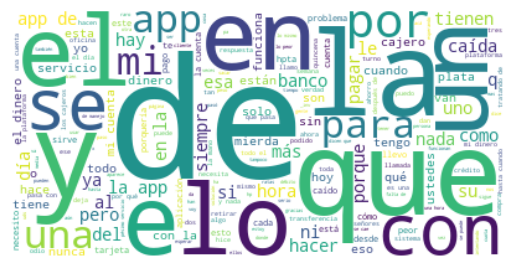

In [727]:
wc = WordCloud(background_color="white", repeat=True)
wc.generate(base_of_text['😡'])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [728]:
import nltk
nltk.download('stopwords') # students change to spacy!
from nltk.corpus import stopwords
stopwords.words('spanish')
print(stopwords.words()[1203:1230])

['nondik', 'nongo', 'nor', 'nora', 'on', 'ondoren', 'ondorio', 'ondorioz', 'ondorioz', 'orain', 'ordea ', 'orduan', 'orduan', 'orduan ', 'orduko', 'ordura', 'orobat', 'ostean', 'ostera', 'osterantzean ', 'pentsatuz', 'ustez', 'ze', 'zein', 'zein ', 'zen', 'zen']


[nltk_data] Downloading package stopwords to /Users/ces/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [729]:
en_stops = set(stopwords.words('spanish'))
all_words = ['There', 'is', 'a', 'tree','near','the','river', 'cómo','tan', 'alguna', 'casi', 'vaya']
for word in all_words:
    if word not in en_stops:
        print(word)
custom_stop_words = ['alguna', 'near', 'cómo',  'casi', 'vaya', ',']  # Replace with your custom stop words
en_stops.update(custom_stop_words)
for word in all_words:
    if word not in en_stops:
        print(word, 'added')

There
is
tree
near
the
river
cómo
tan
alguna
casi
vaya
There added
is added
tree added
the added
river added
tan added


In [730]:
df

,tweet,emoticons,y,feeling
0,,😁,Smile,Positive
1,dejen de responder mierda que no funciona co...,😤,Angry,Negative
2,"hágale doc, ya le paso el de cuenta de",🤗,Smile,Positive
3,por primera vez leí eso del día a día de y de...,😔,Sad,Negative
4,"te odio, pero te necesito",😤,Angry,Negative
...,...,...,...,...
2847,me tiene la vida aburrida con su bloqueadera ...,😡,Angry,Negative
2848,si tienen la oportunidad de abrir cuenta en d...,🤬,Angry,Negative
2849,esto no es cierto! sigue caída,😡,Angry,Negative
2850,"hola, olvide la clave de .",👍,Nice,Positive


In [731]:
tweet  =  df.loc[0,'tweet']

In [732]:
custom_stop_words = ['casi', 'pronto', 'tan',  'seguro', 'cúando']  # add to improve!
en_stops.update(custom_stop_words)

def remove_stopwords(tweet):
    new = []
    for word in tweet.split():
        if word not in en_stops:
            new.append(word)
    return " ".join(new)

In [733]:
remove_stopwords('cada día expreso mi inconformidad con la entidad')

'cada día expreso inconformidad entidad'

In [734]:
df['tweet'] =  df['tweet'].apply(lambda x : remove_stopwords(x))

/var/folders/m6/dfg4_p055hl395w0zrtt6dcm0000gn/T/ipykernel_4342/1996230774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] =  df['tweet'].apply(lambda x : remove_stopwords(x))


In [735]:
emojis = df['emoticons'].unique()
base_of_text={}
for emo in emojis:
    base_of_text[emo] = "".join(df[df['emoticons']==emo]['tweet'].values)

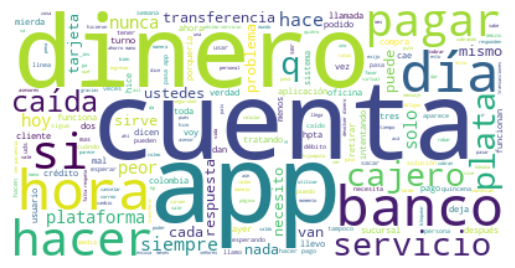

In [736]:
wc = WordCloud(background_color="white", repeat=True)
wc.generate(base_of_text['😡'])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [737]:
def remove_laughs(tweet):
    new = []
    for word in tweet.split():
        if bool(re.fullmatch('a*ja+j[ja]*', word))==False:
            new.append(word)
    return ' '.join(new)

In [738]:
df['tweet'] = df['tweet'].apply(lambda x : remove_laughs(x))

/var/folders/m6/dfg4_p055hl395w0zrtt6dcm0000gn/T/ipykernel_4342/1489628447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] = df['tweet'].apply(lambda x : remove_laughs(x))


In [739]:
def remove_term(regex, tweet):
    new = []
    for word in tweet.split():
        if bool(re.fullmatch(regex, word))==False:
            new.append(word)
    return ' '.join(new)

In [740]:
remove_term('app', 'app no funciona')

'no funciona'

In [741]:
df['tweet'] =  df['tweet'].apply(lambda x: remove_term('miB[b]anco',x))

/var/folders/m6/dfg4_p055hl395w0zrtt6dcm0000gn/T/ipykernel_4342/1550996898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] =  df['tweet'].apply(lambda x: remove_term('miB[b]anco',x))


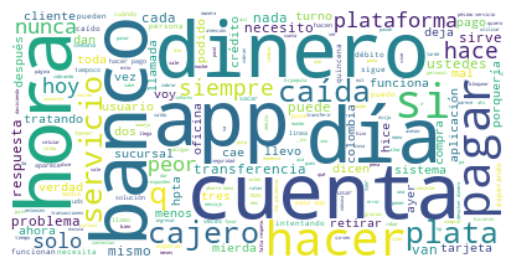

In [742]:
emojis = df['emoticons'].unique()
base_of_text={}
for emo in emojis:
    base_of_text[emo] = "".join(df[df['emoticons']==emo]['tweet'].values)
wc = WordCloud(background_color="white", repeat=True)
wc.generate(base_of_text['😡'])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [743]:
df['feeling'] = np.where(df['feeling']=='Positive',1 ,0)
X  = df['tweet']
y = df['feeling']
X_train, X_test, y_train, y_test  = model_selection.train_test_split(X,y, test_size = 0.25,  random_state=666)

/var/folders/m6/dfg4_p055hl395w0zrtt6dcm0000gn/T/ipykernel_4342/717343918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feeling'] = np.where(df['feeling']=='Positive',1 ,0)


In [744]:
df= df[df['tweet'].apply(lambda tweet: len(str(tweet))!=0)]
df.reset_index(inplace=True, drop=True)

In [745]:
from sklearn.feature_extraction.text import CountVectorizer

In [746]:
### Logistic Regression
def grid_search_lr(X_train, y_train):
    model = LogisticRegression(random_state=666, max_iter=1000)
    class_weight =  [{1:0.5, 0:0.5}]
    solvers = ['liblinear']
    penalty = ['l2','l1', ]
    c_values = [1000, 100,50, 10,1,0.1 ]
    grid = dict(solver=solvers,penalty=penalty,C=c_values, class_weight= class_weight)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scorer = make_scorer(f1_score, average = 'weighted')
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=scorer,error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    best_params = grid_result.best_params_
    return best_params

In [747]:
# vectorization
vect = CountVectorizer().fit(X_train)
vect.get_feature_names_out()
X_train_vectorized = vect.transform(X_train)
params = grid_search_lr(X_train_vectorized, y_train)

# We are going to predict
model = LogisticRegression(penalty = params['penalty'],
                           class_weight=params['class_weight'],
                           solver = params['solver'],
                           C = params['C'],
                           random_state =123)
print(params)

{'C': 10, 'class_weight': {1: 0.5, 0: 0.5}, 'penalty': 'l2', 'solver': 'liblinear'}


/Users/ces/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [748]:
model.fit(X_train_vectorized, y_train)
preds = model.predict(vect.transform(X_test))
print(classification_report(y_test, preds))
import numpy as np
f_names = np.array(vect.get_feature_names_out())
sorted_coef  = model.coef_[0].argsort()
print(f_names[sorted_coef][0:5])

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       604
           1       0.73      0.22      0.34       109

    accuracy                           0.87       713
   macro avg       0.80      0.60      0.63       713
weighted avg       0.85      0.87      0.84       713

['mierda' 'pasa' 'hpta' 'caídos' 'aplicación']


In [749]:
from imblearn.under_sampling import RandomUnderSampler

In [750]:
X_train = pd.DataFrame(X_train)
rus = RandomUnderSampler(random_state=1234)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_train = X_train['tweet']

In [751]:
vect = CountVectorizer().fit(X_train)
#vect.get_feature_names_out()
X_train_vectorized = vect.transform(X_train)
model.fit(X_train_vectorized, y_train)
preds = model.predict(vect.transform(X_test))
print(classification_report(y_test, preds))
import numpy as np
f_names = np.array(vect.get_feature_names_out())
sorted_coef  = model.coef_[0].argsort()
print(f_names[sorted_coef][0:5])

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       604
           1       0.28      0.74      0.41       109

    accuracy                           0.67       713
   macro avg       0.61      0.70      0.59       713
weighted avg       0.83      0.67      0.72       713

['hpta' 'sirve' 'vez' 'hora' 'mierda']


In [752]:
from sklearn.svm import SVC

def grid_SVM(X_train, y_train, performance_metric='f1', resultsGrid=False):
    model = SVC(random_state=666)
    C = np.linspace(0.1 , 50, 250)
    kernels = ['poly', 'rbf','sigmoid', 'linear' ]
    gamma = ['scale', 'auto']
    grid = dict(C = C, kernel = kernels, gamma = gamma)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=performance_metric,error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    if resultsGrid==True:
        return grid_result.cv_results_
    else:
        return  grid_result.best_estimator_

In [753]:
best_model = grid_SVM(X_train_vectorized, y_train)
preds = best_model.predict(vect.transform(X_test))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       604
           1       0.25      0.73      0.37       109

    accuracy                           0.62       713
   macro avg       0.59      0.66      0.55       713
weighted avg       0.82      0.62      0.67       713



In [756]:
def grid_RandomForest(X_train, y_train):
  model = RandomForestClassifier(random_state=0)
  n_estimators = np.arange(10,100,1)
  criterion = ['gini', 'entropy', 'log_loss']
  min_samples_split = [0.05, 0.1,]
  max_depth = [2,3,4,10]
  grid = dict(n_estimators = n_estimators, criterion = criterion,  
              min_samples_split = min_samples_split, max_depth = max_depth)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                            scoring='f1',error_score='raise')
  grid_result = grid_search.fit(X_train, y_train)
  return  grid_result.best_estimator_

In [757]:
best_model = grid_RandomForest(X_train_vectorized, y_train)
preds = best_model.predict(vect.transform(X_test))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.38      0.54       604
           1       0.20      0.85      0.32       109

    accuracy                           0.45       713
   macro avg       0.57      0.62      0.43       713
weighted avg       0.82      0.45      0.51       713

